# Resnet + transfer 
Instead of training from scratch, we can use a pretrained model, like ResNet18 or ResNet34, with:
- frozen early layers
- fine-tuned later layers
Transfer learning can help achieve better performance and reduce training time, as the model has already learned useful features from the large dataset.

First, we will use a ResNet18 model from torchvision.models. The model will be pretrained on the ImageNet dataset, a large dataset with millions of images of many different classes. The final layer of the ResNet18 model is modified to match the binary output for our Pneumonia classification. Then we will repeat training with a ResNet34 model and see which one performs best.

## Import required libraries


In [1]:
import os
import sys
import torch
from torchinfo import summary
module_path = os.path.abspath(os.path.join('..')) # project root
# add project root to sys.path
if module_path not in sys.path:
    sys.path.append(module_path) 
from src.data_loader import get_dataloader
from src.transforms import get_train_transforms, get_val_transforms
from src.models import resnet
from src.train import train_model
from src.evaluate import evaluate_model
from src.plot_metrics import plot_learningcurve, plot_confusionmatrix, plot_learningrate

## Configuration
Set hyperparameters and device for training. Use GPU if available, otherwise use the CPU

In [2]:
data_dir = "../data/raw/chest_xray"
batch_size = 32
epochs = 10
learning_rate = 1e-4 # good starting point for fine-tuning pretrained models
img_size = 224 #
n_channels = 1 

# get device for training
#device  = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"


## Load data
The training data is augmented to improve performance and the dataset is balanced through resampling.

In [3]:
# augment and balance the data

train_transform = get_train_transforms(img_size,augment=True)
val_transform = get_val_transforms(img_size)
# set num_workers to 0, safer on Windows with CPU
train_dataloader = get_dataloader(os.path.join(data_dir,'train'), batch_size=batch_size, num_workers=0,transform=train_transform,balance=True)
val_dataloader = get_dataloader(os.path.join(data_dir,'val'), batch_size=batch_size, num_workers=0,transform=val_transform)
test_dataloader = get_dataloader(os.path.join(data_dir,'test'), batch_size=batch_size, num_workers=0,transform=val_transform)

## 1. Resnet18 model (freeze layers)
Use a pre-trained Resnet18 model and freeze all layers except the final classification head. This reduces the risk of overfitting. After a few epocs we could fine-tune te model further by unfreezing some of te deeper layers, and continque training at a lower learning rage.
### Model setup

In [ ]:
model_resnet18_freeze = resnet.get_resnet18(pretrained=True, grayscale=True, freeze= True).to(device)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()


head_params = [
    {'params': model_resnet18_freeze.conv1.parameters(),'lr':learning_rate},
    {'params': model_resnet18_freeze.fc.parameters(),'lr': learning_rate}
    ]
#optimizer with weightdecay
optimizer = torch.optim.AdamW(head_params, weight_decay=1e-4)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs,eta_min=1e-6)

# print the model summary
summary(model_resnet18_freeze,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (3,136)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]  

### Train the model  - warm-up/ head-only stage

In [ ]:
# train for 10 epochs
metrics_history_rn18_freeze = train_model(model_resnet18_freeze,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs=epochs,scheduler=scheduler)

 Epoch 1 / 5:


Training: 100%|██████████| 163/163 [06:09<00:00,  2.27s/it]


  Average train loss:0.623177  
 Accuracy on the train dataset: 69.59%


Validation: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


  Average val loss:0.623420  
 Accuracy on the validation dataset: 69.39%
 Epoch 2 / 5:


Training: 100%|██████████| 163/163 [06:10<00:00,  2.27s/it]


  Average train loss:0.538128  
 Accuracy on the train dataset: 82.55%


Validation: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


  Average val loss:0.570813  
 Accuracy on the validation dataset: 75.00%
 Epoch 3 / 5:


Training: 100%|██████████| 163/163 [06:25<00:00,  2.36s/it]


  Average train loss:0.486437  
 Accuracy on the train dataset: 84.82%


Validation: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


  Average val loss:0.540853  
 Accuracy on the validation dataset: 76.60%
 Epoch 4 / 5:


Training: 100%|██████████| 163/163 [06:09<00:00,  2.27s/it]


  Average train loss:0.451839  
 Accuracy on the train dataset: 86.45%


Validation: 100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


  Average val loss:0.541061  
 Accuracy on the validation dataset: 76.92%
 Epoch 5 / 5:


Training: 100%|██████████| 163/163 [05:42<00:00,  2.10s/it]


  Average train loss:0.426173  
 Accuracy on the train dataset: 87.12%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

  Average val loss:0.511893  
 Accuracy on the validation dataset: 78.69%
Done!


### fine-tune the model


In [ ]:
for name, param in model_resnet18_freeze.named_parameters():
    if "layer4" in name or "conv1" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


optimizer = torch.optim.Adam([
    {'params':model_resnet18_freeze.conv1.parameters(), 'lr':1e-5,'weight_decay':1e-5}
    {'params':model_resnet18_freeze.layer4.parameters(), 'lr':1e-5,'weight_decay':1e-5},
    {'params': model_resnet18_freeze.fc.parameters(),'lr':1e-4,'weight_decay':1e-5}
    ])

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5,gamma=0.1)


metrics_history_rn18_finetuned = train_model(model_resnet18,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs=5,scheduler=scheduler)

 Epoch 1 / 5:


Training: 100%|██████████| 163/163 [06:13<00:00,  2.29s/it]


  Average train loss:0.246090  
 Accuracy on the train dataset: 91.72%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


  Average val loss:0.293150  
 Accuracy on the validation dataset: 88.62%
 Epoch 2 / 5:


Training: 100%|██████████| 163/163 [06:07<00:00,  2.25s/it]


  Average train loss:0.157840  
 Accuracy on the train dataset: 94.00%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


  Average val loss:0.248985  
 Accuracy on the validation dataset: 90.38%
 Epoch 3 / 5:


Training: 100%|██████████| 163/163 [05:58<00:00,  2.20s/it]


  Average train loss:0.129278  
 Accuracy on the train dataset: 95.28%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


  Average val loss:0.238521  
 Accuracy on the validation dataset: 91.51%
 Epoch 4 / 5:


Training: 100%|██████████| 163/163 [05:50<00:00,  2.15s/it]


  Average train loss:0.112647  
 Accuracy on the train dataset: 95.69%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


  Average val loss:0.237832  
 Accuracy on the validation dataset: 91.19%
 Epoch 5 / 5:


Training: 100%|██████████| 163/163 [05:55<00:00,  2.18s/it]


  Average train loss:0.100067  
 Accuracy on the train dataset: 95.88%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

  Average val loss:0.268819  
 Accuracy on the validation dataset: 89.90%
Done!


### Save the model

In [ ]:
torch.save(model_resnet18,'../models/resnet18_5ep_finetuned.pth')

### Results

Validation: 100%|██████████| 20/20 [00:32<00:00,  1.64s/it]


Accuracy on the test set: 92.15%
Precision: 0.89, Recall: 0.99, F1 score: 0.94, AUC: 0.90
classification_report :              precision    recall  f1-score   support

           0       0.99      0.80      0.88       234
           1       0.89      0.99      0.94       390

    accuracy                           0.92       624
   macro avg       0.94      0.90      0.91       624
weighted avg       0.93      0.92      0.92       624



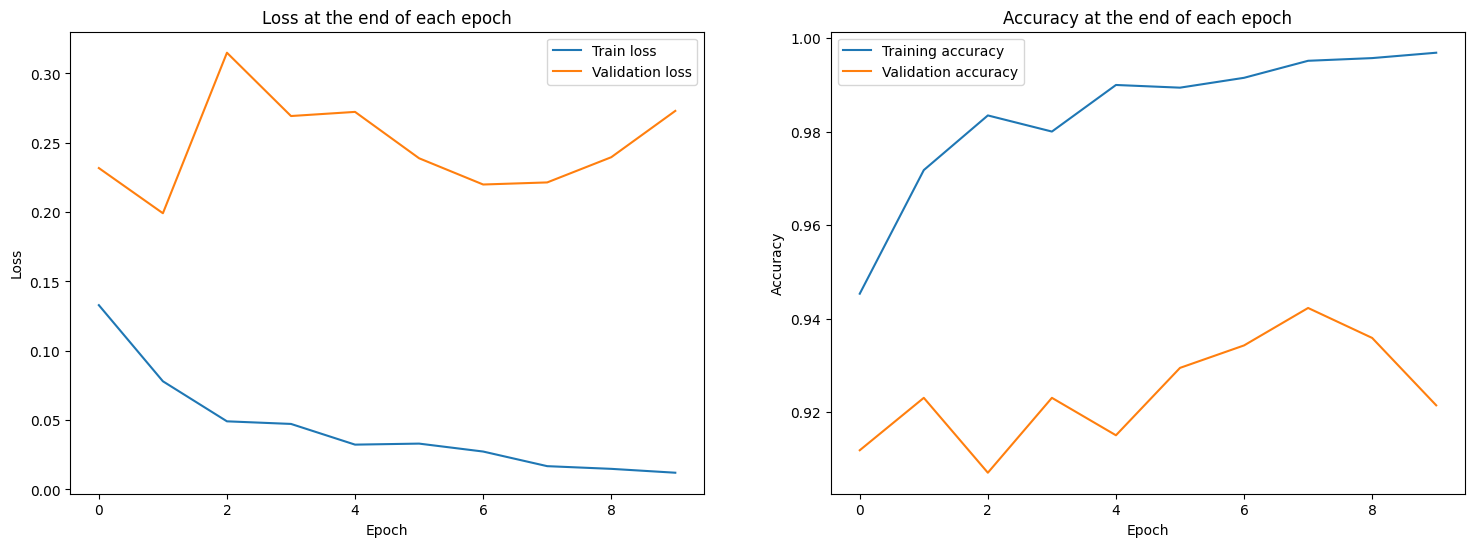

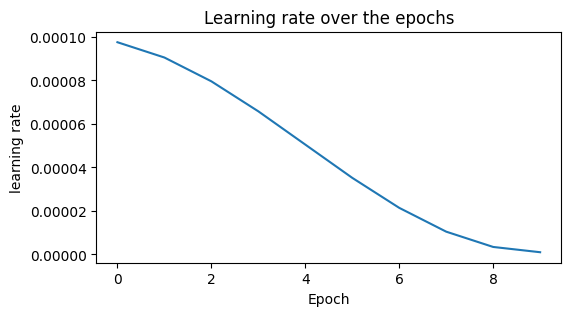

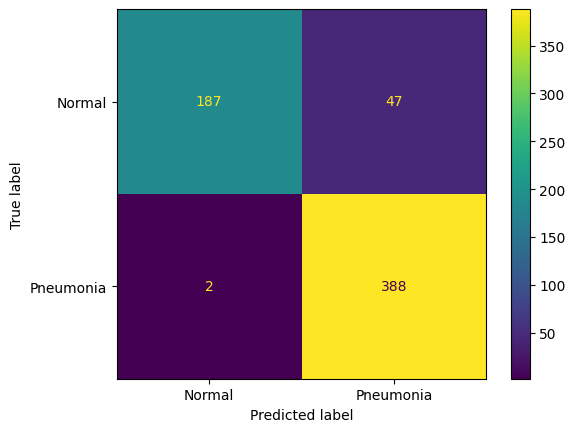

In [8]:
plot_learningcurve(metrics_history_rn18)

plot_learningrate(metrics_history_rn18['lrs'])

eval_metrics_rn18 = evaluate_model(model_resnet18, test_dataloader, loss_function, device="cpu")
       
print(f"Accuracy on the test set: {eval_metrics_rn18['accuracy']:.2%}")

print(f"Precision: {eval_metrics_rn18['precision']:.2f}, Recall: {eval_metrics_rn18['recall']:.2f}, F1 score: {eval_metrics_rn18['f1']:.2f}, AUC: {eval_metrics_rn18['auc']:.2f}")

print(f'classification_report :{eval_metrics_rn18['classification report']}')


# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics_rn18['confusion matrix'])

## 2 ResNet18 model (no freezing)
let's also try to train all the layers of the pre-trained ResNet18 model on our dataset. 

### Model setup

In [ ]:
model_resnet18_full = resnet.get_resnet18(pretrained=True, grayscale=True, freeze= False).to(device)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

#optimizer with weightdecay
optimizer = torch.optim.Adam(model_resnet18_full.parameters(), lr=learning_rate,weight_decay=1e-5)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs,eta_min=1e-6)

# print the model summary
summary(model_resnet18_full,input_size=[batch_size,n_channels,img_size,img_size])

### Train the model


## 2. ResNet34 model

### Model setup

In [ ]:
model_resnet34 = resnet.get_resnet34(pretrained=True, grayscale=True, freeze=False).to(device)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

#optimizer with weightdecay
optimizer = torch.optim.Adam(model_resnet34.parameters(), lr=learning_rate,weight_decay=1e-5)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs,eta_min=1e-6)

# print the model summary
summary(model_resnet34,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        3,136
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

### Train the model

In [11]:
metrics_history_rn34 = train_model(model_resnet34,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs,scheduler)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [16:08<00:00,  5.94s/it]


  Average train loss:0.152537  
 Accuracy on the train dataset: 93.67%


Validation: 100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


  Average val loss:0.301519  
 Accuracy on the validation dataset: 89.26%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [14:57<00:00,  5.51s/it]


  Average train loss:0.080865  
 Accuracy on the train dataset: 96.97%


Validation: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


  Average val loss:0.247207  
 Accuracy on the validation dataset: 91.03%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [13:45<00:00,  5.06s/it]


  Average train loss:0.059120  
 Accuracy on the train dataset: 97.89%


Validation: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


  Average val loss:0.444758  
 Accuracy on the validation dataset: 89.42%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [12:12<00:00,  4.49s/it]


  Average train loss:0.043108  
 Accuracy on the train dataset: 98.43%


Validation: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


  Average val loss:0.209525  
 Accuracy on the validation dataset: 93.43%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [12:16<00:00,  4.52s/it]


  Average train loss:0.034882  
 Accuracy on the train dataset: 99.00%


Validation: 100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


  Average val loss:0.312411  
 Accuracy on the validation dataset: 91.19%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [12:23<00:00,  4.56s/it]


  Average train loss:0.016834  
 Accuracy on the train dataset: 99.46%


Validation: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


  Average val loss:0.357500  
 Accuracy on the validation dataset: 91.03%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [12:35<00:00,  4.63s/it]


  Average train loss:0.027902  
 Accuracy on the train dataset: 99.14%


Validation: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


  Average val loss:0.311191  
 Accuracy on the validation dataset: 91.35%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [12:59<00:00,  4.78s/it]


  Average train loss:0.017085  
 Accuracy on the train dataset: 99.44%


Validation: 100%|██████████| 20/20 [00:28<00:00,  1.45s/it]


  Average val loss:0.333479  
 Accuracy on the validation dataset: 90.87%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [12:46<00:00,  4.70s/it]


  Average train loss:0.012990  
 Accuracy on the train dataset: 99.58%


Validation: 100%|██████████| 20/20 [00:32<00:00,  1.64s/it]


  Average val loss:0.352343  
 Accuracy on the validation dataset: 90.87%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [13:39<00:00,  5.03s/it]


  Average train loss:0.008794  
 Accuracy on the train dataset: 99.77%


Validation: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]

  Average val loss:0.348116  
 Accuracy on the validation dataset: 91.03%
Done!


In [12]:
### Save the model

In [15]:
torch.save(model_resnet34,'../models/resnet34_10ep.pth')

### Results

Validation: 100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


Accuracy on the test set: 91.03%
Precision: 0.88, Recall: 0.99, F1 score: 0.93, AUC: 0.88
classification_report :              precision    recall  f1-score   support

           0       0.98      0.77      0.87       234
           1       0.88      0.99      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.88      0.90       624
weighted avg       0.92      0.91      0.91       624



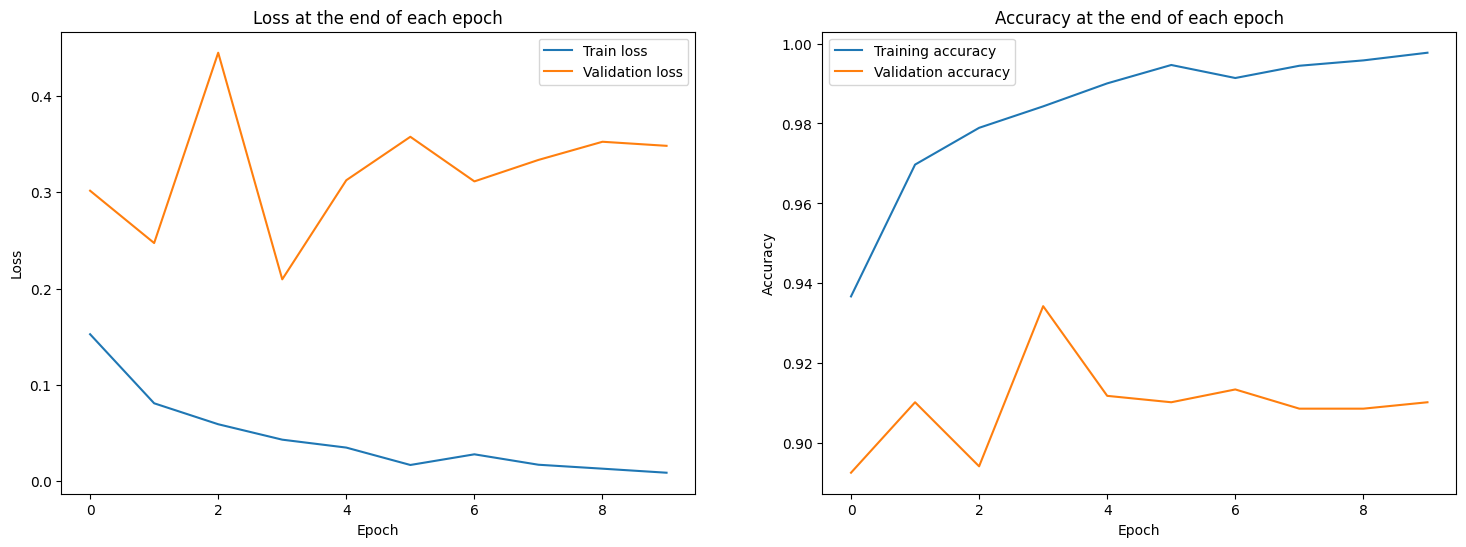

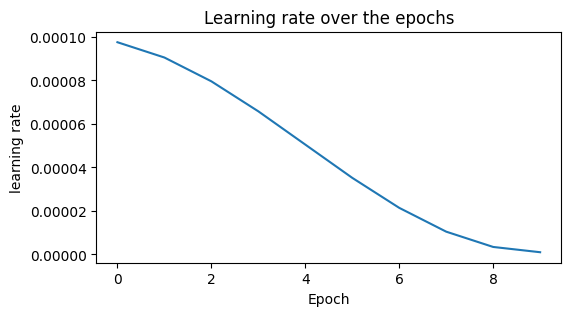

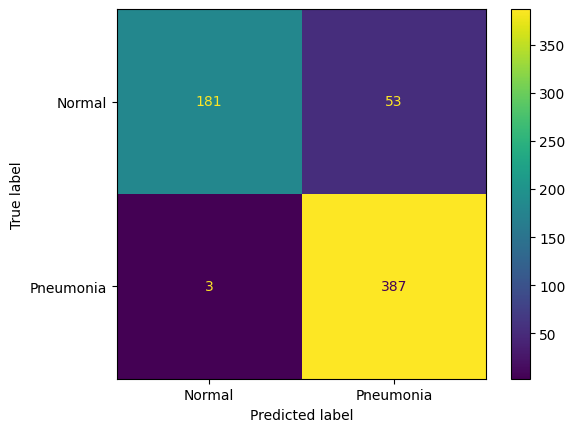

In [16]:
plot_learningcurve(metrics_history_rn34)

plot_learningrate(metrics_history_rn34['lrs'])

eval_metrics_rn34 = evaluate_model(model_resnet34, test_dataloader, loss_function, device="cpu")
       
print(f"Accuracy on the test set: {eval_metrics_rn34['accuracy']:.2%}")

print(f"Precision: {eval_metrics_rn34['precision']:.2f}, Recall: {eval_metrics_rn34['recall']:.2f}, F1 score: {eval_metrics_rn34['f1']:.2f}, AUC: {eval_metrics_rn34['auc']:.2f}")

print(f'classification_report :{eval_metrics_rn34['classification report']}')


# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics_rn34['confusion matrix'])